In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import pandas as pd


#  PROBLEM DEFINITION

## Description of the Problem

Traffic congestion is a major issue in urban areas, leading to delays, increased fuel consumption, and pollution. Traditional traffic light timing systems often use fixed schedules that do not adapt to real-time traffic conditions. This project aims to optimize traffic light timings using a Genetic Algorithm (GA) to minimize traffic stops and travel time while improving the overall flow of vehicles.

## Suitability of Genetic Algorithms

Genetic Algorithms (GAs) are particularly suited for this problem because:
- **Large Search Space:** There are many possible combinations of traffic light timings, making brute force impractical.
- **Optimization Potential:** GA can efficiently explore and exploit traffic light configurations to find near-optimal solutions.
- **Adaptability:** Unlike rule-based systems, GA can adapt to different road network structures.
- **Parallelism:** Multiple solutions can evolve simultaneously, allowing diverse optimization approaches.

## Complexity of the Problem
- **Computational Complexity:** The problem involves multiple variables (green, yellow, and red_stop timings), making it computationally intensive.
- **Constraint Handling:** Opposite traffic lights need to be synchronized, adding additional constraints.
- **Simulation Requirements:** Evaluating fitness requires simulating multiple vehicles, which can be time-consuming.


# Build Road Network

## Road Network

In [2]:
NUM_NODES = 10  # Number of intersections
road_network = nx.random_geometric_graph(NUM_NODES, 0.3)

road_distances = {}
road_speeds = {}

for (start, end) in road_network.edges():
    distance = random.randint(200, 1000)  # Distance in meters
    speed = random.choice([11.11, 13.89, 16.67])  # 40 km/h, 50 km/h, 60 km/h in m/s

    road_distances[(start, end)] = distance
    road_distances[(end, start)] = distance
    road_speeds[(start, end)] = speed
    road_speeds[(end, start)] = speed

In [3]:
def ensure_fully_connected(road_network):
    components = list(nx.connected_components(road_network))
    if len(components) > 1:
        print(f"Graph has {len(components)} disconnected components. Connecting them...")
        for i in range(len(components) - 1):
            node_a = random.choice(list(components[i]))
            node_b = random.choice(list(components[i + 1]))
            road_network.add_edge(node_a, node_b)
            road_distances[(node_a, node_b)] = random.randint(200, 1000)
            road_distances[(node_b, node_a)] = road_distances[(node_a, node_b)]
            road_speeds[(node_a, node_b)] = random.choice([11.11, 13.89, 16.67])
            road_speeds[(node_b, node_a)] = road_speeds[(node_a, node_b)]
    return road_network

road_network = ensure_fully_connected(road_network)

Graph has 3 disconnected components. Connecting them...


## Find the Opposite Traffic Lights

In [4]:
def find_opposite_lights(road_network):
    opposite_lights = {}
    for node in road_network.nodes():
        neighbors = list(road_network.neighbors(node))
        if len(neighbors) < 2:
            continue
        sorted_neighbors = sorted(neighbors, key=lambda x: road_distances.get((node, x), 9999))
        for i in range(len(sorted_neighbors) - 1):
            opposite_lights[sorted_neighbors[i]] = sorted_neighbors[i + 1]
            opposite_lights[sorted_neighbors[i + 1]] = sorted_neighbors[i]
    return opposite_lights

opposite_lights = find_opposite_lights(road_network)

# Traffic Light Class (Individual)

## Individual Representation
Each **individual** in the Genetic Algorithm represents a **complete traffic light configuration** for all intersections in the road network.

- **Chromosome:** A single traffic light configuration for all intersections in the road network.
- **Genes:** Each traffic light is considered a gene within the chromosome and has the following attributes:
  - **Green Time:** Duration for which the light remains green.
  - **Yellow Time:** Duration for the yellow transition light.
  - **Red_Stop Time:** Buffer time before switching to green to prevent crashes.
  - **Red Time:** The duration the light remains red, which depends on the opposite traffic light.
- **Population:** A set of multiple traffic light configurations (chromosomes) that evolve over generations to find the best solution.

In [5]:
class TrafficLightNode:
    def __init__(self, node_id):
        self.node_id = node_id
        self.green = random.randint(20, 60)
        self.yellow = random.randint(3, 8)
        self.red_stop = random.randint(3, 5)
        self.red_time = 0

    def mutate(self, mutation_rate=0.1):
        if random.random() < mutation_rate:
            self.green = max(5, self.green + random.randint(-5, 5))
        if random.random() < mutation_rate:
            self.yellow = max(2, self.yellow + random.randint(-1, 1))
        if random.random() < mutation_rate:
            self.red_stop = max(2, self.red_stop + random.randint(-2, 2))


# Adjust Red Time base on opposite lights

In [6]:
def adjust_red_timings(chromosome, opposite_lights):
    for node_id, traffic_light in chromosome.items():
        if node_id in opposite_lights:
            opposite_id = opposite_lights[node_id]
            opposite_light = chromosome.get(opposite_id)
            if opposite_light:
                traffic_light.red_stop = random.randint(3, 5)
                traffic_light.red_time = opposite_light.green + opposite_light.yellow + opposite_light.red_stop

# Cross Over

- **Uniform Crossover:** Traffic light attributes (green, yellow, red_stop) are randomly chosen from two parent solutions to create a new child configuration.
- Helps mix good timing patterns from different configurations to improve performance.

In [7]:
def crossover(parent1, parent2):
    """Combines two parent traffic light configurations to create a new child."""
    child = {}
    for node_id in parent1:
        if random.random() < 0.5:
            child[node_id] = TrafficLightNode(node_id)
            child[node_id].green = parent1[node_id].green
            child[node_id].yellow = parent1[node_id].yellow
            child[node_id].red_stop = parent1[node_id].red_stop
        else:
            child[node_id] = TrafficLightNode(node_id)
            child[node_id].green = parent2[node_id].green
            child[node_id].yellow = parent2[node_id].yellow
            child[node_id].red_stop = parent2[node_id].red_stop
    return child

# Cost Function: Measuring Optimization Performance
The cost function evaluates how well a given traffic light configuration performs in terms of **minimizing travel time, reducing stops, and improving green wave efficiency.

#### **How It Works**:
1. **Simulating Traffic Flow**: Vehicles are randomly assigned start and destination points.
2. **Shortest Path Calculation**: Vehicles follow the shortest path between intersections.
3. **Traffic Light Evaluation**:
   - If a vehicle arrives at a red light, it must stop and wait.
   - If a vehicle arrives at a green light, it continues without stopping.
4. **Metrics Used to Evaluate Performance**:
   - **Total Stops:** Lower stops indicate a better solution.
   - **Total Travel Time:** Lower travel time means more efficient traffic flow.
   - **Green Wave Efficiency:** Percentage of cars that pass without stopping.

#### **Formula for the Fitness Score**:
Fitness Score = 100 − ( Total Travel Time + Total Stops )
- Higher fitness means a more optimized traffic system.

#### **Formula for Green Wave Efficiency**:
Green Wave Efficiency =( Cars That Did Not Stop / Total Cars )×100%
- Higher Green Wave Efficiency indicates a smoother traffic flow with fewer stops.


In [8]:
def network_fitness_function(chromosome, num_vehicles=500):
    total_stops = 0
    total_travel_time = 0
    successful_green_passes = 0

    for _ in range(num_vehicles):
        start = random.randint(0, NUM_NODES - 1)
        end = random.randint(0, NUM_NODES - 1)
        if start == end:
            continue

        try:
            path = nx.shortest_path(road_network, source=start, target=end)
        except nx.NetworkXNoPath:
            continue

        stops = 0
        travel_time = 0
        for i in range(len(path) - 1):
            current_node = path[i]
            next_node = path[i + 1]
            time_to_next = road_distances.get((current_node, next_node), 500) / road_speeds.get((current_node, next_node), 13.89)
            next_light = chromosome[next_node]
            if time_to_next > next_light.green:
                stops += 1
                travel_time += next_light.red_time
            else:
                successful_green_passes += 1
            travel_time += time_to_next

        total_stops += stops
        total_travel_time += travel_time

    avg_stops = total_stops / max(num_vehicles, 1)
    avg_travel_time = total_travel_time / max(num_vehicles, 1)
    green_wave_efficiency = (successful_green_passes / max(num_vehicles * (NUM_NODES - 1), 1)) * 100

    return 1 / (avg_travel_time + avg_stops + 1e-6), green_wave_efficiency #1e -6 is 1 x 10 power of -6

# Genetic Algorithm

In [9]:
def plot_fitness_evolution(fitness_history, green_wave_history):
    generations = list(range(len(fitness_history)))
    plt.figure(figsize=(10, 5))
    plt.plot(generations, fitness_history, marker='o', label="Fitness Score", linestyle='-')
    plt.plot(generations, green_wave_history, marker='s', label="Green Wave Efficiency (%)", linestyle='--')
    plt.xlabel("Generations")
    plt.ylabel("Performance")
    plt.title("Traffic Light Optimization: Fitness and Green Wave Efficiency")
    plt.legend()
    plt.show()

In [10]:
def genetic_algorithm(population_size, generations):
    population = [{i: TrafficLightNode(i) for i in range(NUM_NODES)} for _ in range(population_size)]
    fitness_history = []
    green_wave_history = []
    best_chromosome = None

    for generation in range(generations):
        for chromosome in population:
            adjust_red_timings(chromosome, opposite_lights)

        fitness_scores = [(network_fitness_function(chromosome), chromosome) for chromosome in population]
        fitness_scores.sort(key=lambda x: x[0][0], reverse=True)

        best_fitness, best_green_wave = fitness_scores[0][0]
        best_chromosome = fitness_scores[0][1]
        fitness_history.append(best_fitness)
        green_wave_history.append(best_green_wave)

        print(f"Generation {generation}: Best Fitness = {best_fitness:.5f}, Green Wave Efficiency = {best_green_wave:.2f}%")

        # Select top 2 parents
        parent1, parent2 = fitness_scores[0][1], fitness_scores[1][1]

        # Generate new population using crossover
        new_population = [crossover(parent1, parent2) for _ in range(population_size)]

        # Apply mutation
        for child in new_population:
            for light in child.values():
                light.mutate()

        population = new_population

    plot_fitness_evolution(fitness_history, green_wave_history)
    return best_chromosome


# RUN ALGORITHM

# Plot Fitness Evolution

Generation 0: Best Fitness = 0.00642, Green Wave Efficiency = 12.89%
Generation 1: Best Fitness = 0.00657, Green Wave Efficiency = 10.69%
Generation 2: Best Fitness = 0.00726, Green Wave Efficiency = 13.11%
Generation 3: Best Fitness = 0.00747, Green Wave Efficiency = 12.71%
Generation 4: Best Fitness = 0.00719, Green Wave Efficiency = 13.98%
Generation 5: Best Fitness = 0.00740, Green Wave Efficiency = 12.69%
Generation 6: Best Fitness = 0.00719, Green Wave Efficiency = 13.51%
Generation 7: Best Fitness = 0.00757, Green Wave Efficiency = 12.73%
Generation 8: Best Fitness = 0.00745, Green Wave Efficiency = 13.07%
Generation 9: Best Fitness = 0.00773, Green Wave Efficiency = 13.31%
Generation 10: Best Fitness = 0.00763, Green Wave Efficiency = 12.76%
Generation 11: Best Fitness = 0.00722, Green Wave Efficiency = 13.69%
Generation 12: Best Fitness = 0.00745, Green Wave Efficiency = 12.93%
Generation 13: Best Fitness = 0.00764, Green Wave Efficiency = 12.93%
Generation 14: Best Fitness = 

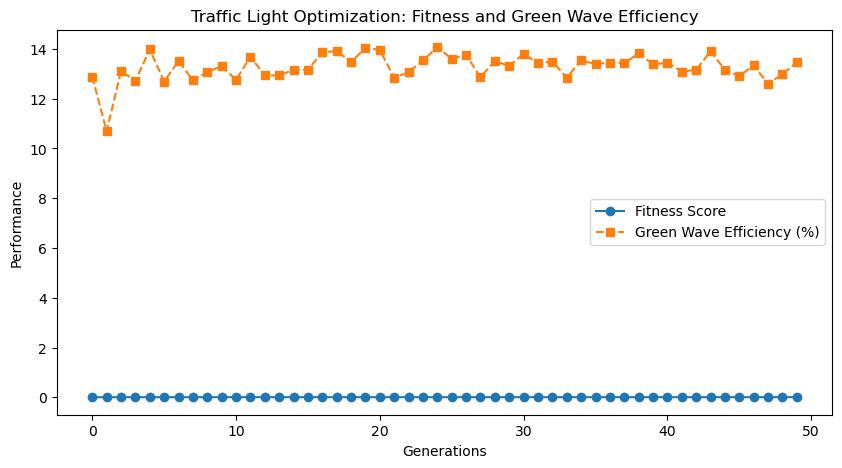

Junction 0 → Green: 45s, Yellow: 5s, Red_Stop: 5s, Red Time: 34s
Junction 1 → Green: 24s, Yellow: 5s, Red_Stop: 4s, Red Time: 84s
Junction 2 → Green: 53s, Yellow: 7s, Red_Stop: 3s, Red Time: 84s
Junction 3 → Green: 5s, Yellow: 2s, Red_Stop: 3s, Red Time: 21s
Junction 4 → Green: 74s, Yellow: 5s, Red_Stop: 4s, Red Time: 33s
Junction 5 → Green: 49s, Yellow: 3s, Red_Stop: 4s, Red Time: 10s
Junction 6 → Green: 31s, Yellow: 11s, Red_Stop: 5s, Red Time: 10s
Junction 7 → Green: 12s, Yellow: 5s, Red_Stop: 5s, Red Time: 10s
Junction 8 → Green: 38s, Yellow: 6s, Red_Stop: 4s, Red Time: 10s
Junction 9 → Green: 32s, Yellow: 6s, Red_Stop: 5s, Red Time: 10s


In [11]:
best_solution = genetic_algorithm(population_size=10, generations=50)

if isinstance(best_solution, dict):
    for node_id, traffic_light in best_solution.items():
        print(f"Junction {node_id} → Green: {traffic_light.green}s, Yellow: {traffic_light.yellow}s, Red_Stop: {traffic_light.red_stop}s, Red Time: {traffic_light.red_time}s")
else:
    print("Error: Best solution is not a valid chromosome dictionary.")


# Results and Conclusions
- **Improved Green Wave Efficiency:** The genetic algorithm successfully optimized traffic lights, leading to a smoother flow of vehicles.
- **Reduced Traffic Stops:** The final configurations significantly lowered the number of stops compared to initial random settings.
- **Visualization of Improvement:** The fitness evolution plot shows steady improvement over generations.